# Clustering to improve logerror

**1.** [**Project Plan**](#Project-Plan)<br>
**2.** [**Data Acquistion**](#acquire_data)<br>
**3.** [**Explore Data**](#explore_data)<br>
**4.** [**Create a Baseline Model**](#baseline_model)<br>
**5.** [**Create and Compare Different Models**](#modeling)<br>
**6.** [**Predict on Test Model**](#predict_test)<br>
**7.** [**Exporting CSV with Predictions**](#csv_export)

## 1. Project Plan

### Background

We've been tasked with using the Clustering ML Algorithm to see if we can improve on logerror estimates.

- Plan and strategize for using Clustering to tackle the problem
- Acquire and prepare zillow data
- Explore data with visuals discuss/combine findings
- Finalize how we want to handle the data
    - missing values
    - imputing
    - outliers
    - etc.
- Use clustering methodologies to find possible features to predict our target > logerror
- Try different models then decide what model we want to move forward with

### Goals

- Improve our original estimate of the log error by using clustering methodologies.
- Identify the driver of logerror
- Build a model to predict logerror

The deliverables for this project are the following data assets:

1. Report detailing our analysis in an .ipynb format
2. Detailed README on a Github and repo containing all files for this project
3. All .py files that are necessary to reproducible work

### Data Dictionary for Selected Features

#### *Target Variable*:

**logerror** - tbd


#### *Independent Variables*:

**tbd** - tbd

#### *Data Scaling*:

**tbd** - tbd

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# general
import pandas as pd
import numpy as np


# explore/ stat
import scipy.stats as stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# support modules
import acquire
import wrangle
import prepare
import split_scale
import cluster
import model

# look at function for summarize plot
# import summarize
# import prepare
# import explore
# import split_scale

# modeling
from sklearn.cluster import KMeans, dbscan
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# view full DF
pd.set_option('display.max_columns', None)

<a id='acquire_data'></a>

# Data Acquistion

Retrieve from the Codeup Zillow_db:

- Latest transactions occured within the year of 2017 for each property
- Logerror
- All fields related to each properties
- Gather descriptions by joining description tables
- Only properties where latitude and longitude are not null
- Only single family homes (SFR)

In [2]:
df = acquire.get_zillow_data()

In [3]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,0.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,5.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,0.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,0.0,1964.0,73681.0,119407.0,45726.0,1533.89,0.006940,2017-01-01


In [4]:
df.shape

(76725, 16)

In [5]:
df = wrangle.handle_nulls(df)

In [6]:
df = wrangle.prepare_zillow(df)

Derive Features

In [7]:
df = prepare.transaction_month(df)

In [8]:
df = prepare.tax_rate(df)

In [9]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,Los_Angeles,Orange,Ventura,age,month,tax_rate
0,14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,0.0,485713.0,1023282.0,537569.0,0.025595,0,1,0,19.0,1,0.010763
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,5.0,88000.0,464000.0,376000.0,0.055619,0,0,1,50.0,1,0.012225
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.0,85289.0,564778.0,479489.0,0.005383,0,1,0,55.0,1,0.011488
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,0.0,108918.0,145143.0,36225.0,-0.103410,1,0,0,47.0,1,0.012247
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,0.0,73681.0,119407.0,45726.0,0.006940,1,0,0,53.0,1,0.012846


In [10]:
df.shape

(76659, 19)

In [11]:
#df.hist(figsize=(36, 20))
#plt.show()

In [12]:
# remove outlier
col_out = ["bathroomcnt", "bedroomcnt", "tax_rate", "calculatedfinishedsquarefeet", "lotsizesquarefeet", "roomcnt", "structuretaxvaluedollarcnt", "taxvaluedollarcnt", "landtaxvaluedollarcnt"]

In [13]:
def remove_outliers_iqr(df, col_out):
    for col in enumerate(col_out):
        col = str(col[1])
        
        q1, q3 = df[col].quantile([.25, .75])
        iqr = q3 - q1
        ub = q3 + 3 * iqr
        lb = q1 - 3 * iqr

        df = df[df[col] <= ub]
        df = df[df[col] >= lb]
    return df

In [14]:
df = remove_outliers_iqr(df, col_out)


In [15]:
# Additional outlier removal
df = df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) & 
         (df.bathroomcnt > 0) & 
         (df.bedroomcnt > 0) & 
         (df.calculatedfinishedsquarefeet < 7000) & 
         (df.tax_rate < .05)
        )]

In [16]:
df = prepare.better_names(df)

In [17]:
# parcelDensity30000 = get_pde(df,30000)
# parcelDensity10000 = get_pde(df,10000)
# parcelDensity3000 = get_pde(df,3000)
# parcelDensity1000 = get_pde(df,1000)
# parcelDensity300 = get_pde(df,300)

In [18]:
# plt.figure(figsize=(14,14))
# plt.axis("off")
# plt.title("Nightclub Plot")
# plt.scatter(df['longitude'].values, df['latitude'].values, c=parcelDensity30000,cmap='inferno', s=1, edgecolor='')

In [19]:
# from scipy.stats import rankdata
# rankScaled30000 = 100*rankdata(parcelDensity30000)/len(parcelDensity30000)
# rankScaled10000 = 100*rankdata(parcelDensity10000)/len(parcelDensity10000)
# rankScaled3000 = 100*rankdata(parcelDensity3000)/len(parcelDensity3000)
# rankScaled1000 = 100*rankdata(parcelDensity1000)/len(parcelDensity1000)
# rankScaled300 = 100*rankdata(parcelDensity300)/len(parcelDensity300)

In [20]:
# fig = plt.figure(figsize=(15,15))

# ax1 = fig.add_subplot(221)
# ax1.set_title('bandwidth = 10,000')
# ax1.set_axis_off()
# ax1.scatter(df['longitude'].values, df['latitude'].values, c=rankScaled10000,cmap='inferno', s=1, edgecolor='')

# ax2 = fig.add_subplot(222)
# ax2.set_title('bandwidth = 3,000')
# ax2.set_axis_off()
# ax2.scatter(df['longitude'].values, df['latitude'].values, c=rankScaled3000,cmap='inferno', s=1, edgecolor='')

# ax3 = fig.add_subplot(223)
# ax3.set_title('bandwidth = 1,000')
# ax3.set_axis_off()
# ax3.scatter(df['longitude'].values, df['latitude'].values, c=rankScaled1000,cmap='inferno', s=1, edgecolor='')

# ax4 = fig.add_subplot(224)
# ax4.set_title('bandwidth = 300')
# ax4.set_axis_off()
# ax4.scatter(df['longitude'].values, df['latitude'].values, c=rankScaled300,cmap='inferno', s=1, edgecolor='')

In [21]:
train, test = split_scale.train_test(df)

In [22]:
print('train:', train.shape)
print('test:', test.shape)

train: (47944, 17)
test: (11986, 17)


In [23]:
train.head()

,longitude,latitude,age,month,bedroomcnt,bathroomcnt,square_footage,lot_size,house_value,land_value,full_value,tax_rate,roomcnt,Los_Angeles,Orange,Ventura,logerror
71843,-117721870.0,33533109.0,49.0,8,4.0,2.0,1448.0,8550.0,81477.0,290648.0,372125.0,0.009979,7.0,0,1,0,0.030902
5668,-118393000.0,34074400.0,44.0,1,2.0,3.0,2753.0,23620.0,147849.0,195895.0,343744.0,0.011757,0.0,1,0,0,0.008091
53838,-117828052.0,33734099.0,55.0,7,4.0,2.0,2016.0,7315.0,117652.0,339232.0,456884.0,0.011564,7.0,0,1,0,0.013780
62826,-117857327.0,33834245.0,39.0,8,2.0,1.0,787.0,7201.0,64574.0,151877.0,216451.0,0.011580,0.0,0,1,0,0.001547
14687,-117812955.0,34025801.0,44.0,3,3.0,2.0,1501.0,10051.0,128004.0,85443.0,213447.0,0.013560,0.0,1,0,0,0.017525


In [24]:
scaler, train_scaled, test_scaled = split_scale.min_max_scaler(train, test)

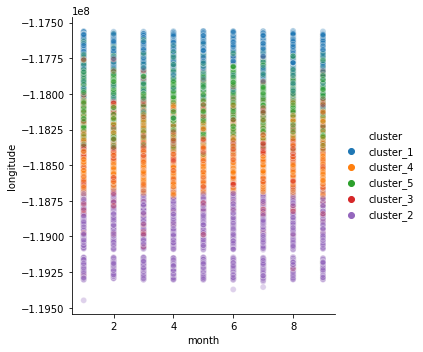

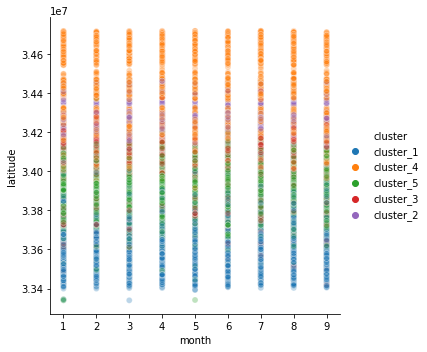

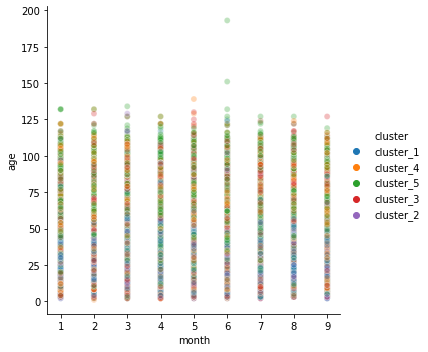

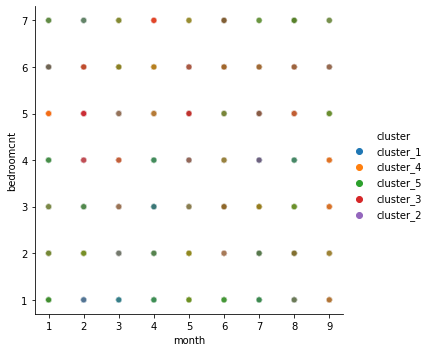

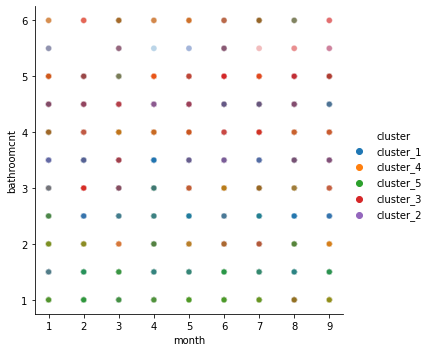

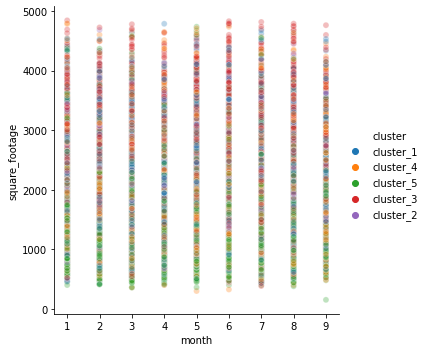

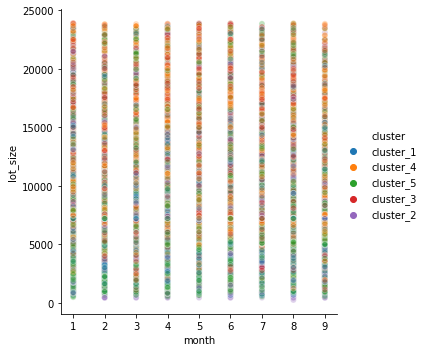

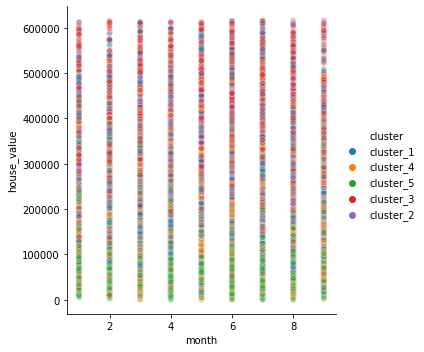

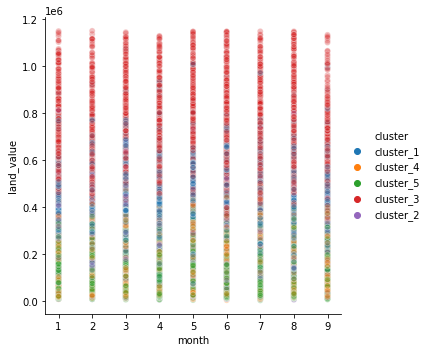

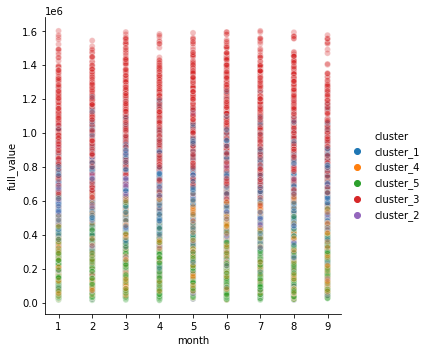

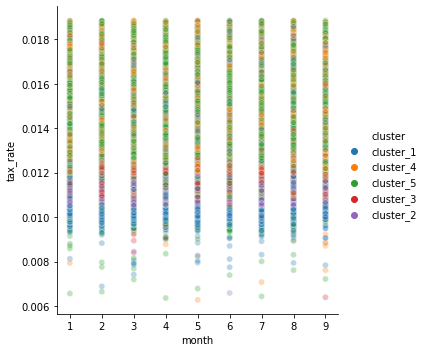

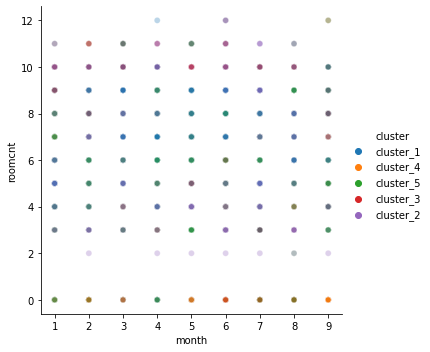

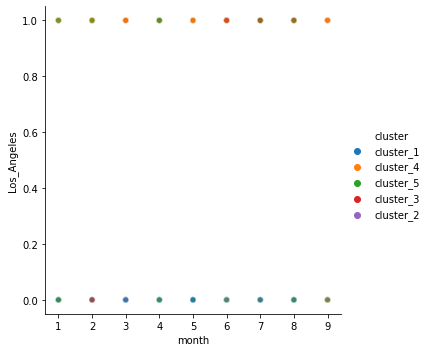

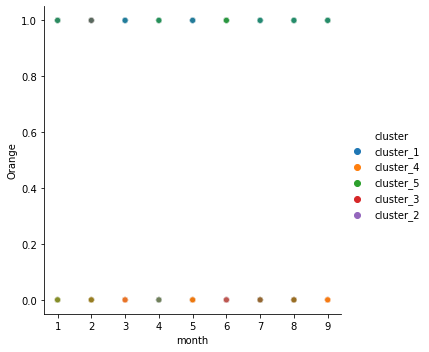

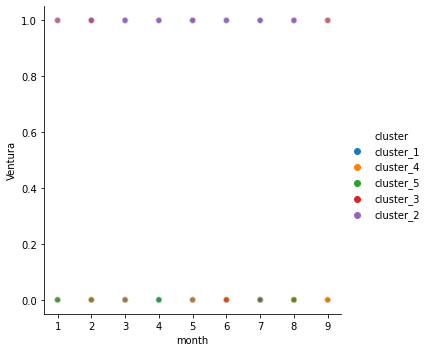

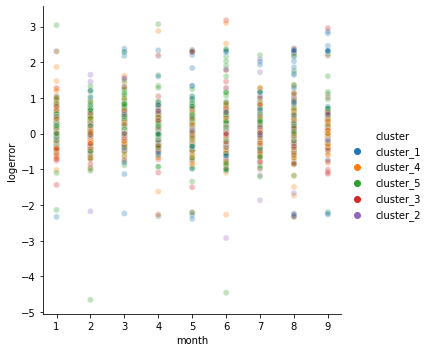

In [25]:
cluster.k_cluster_all(train, "month", 5)

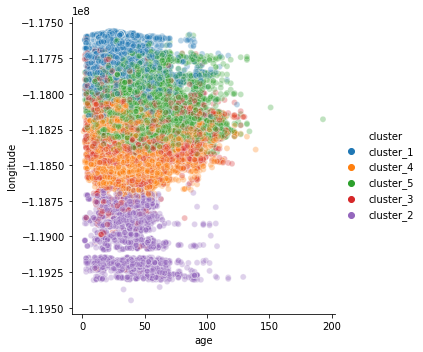

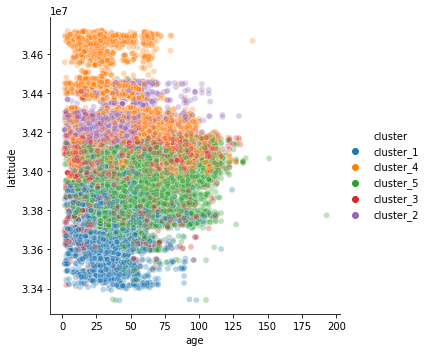

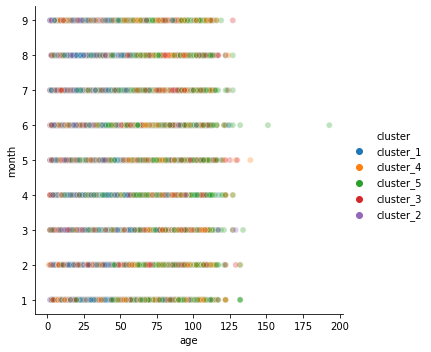

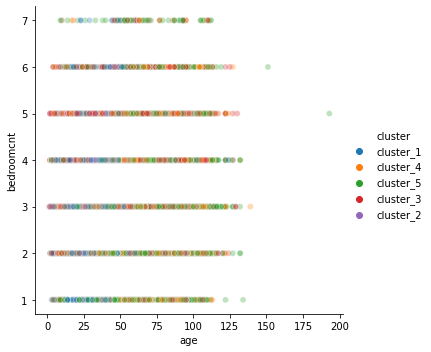

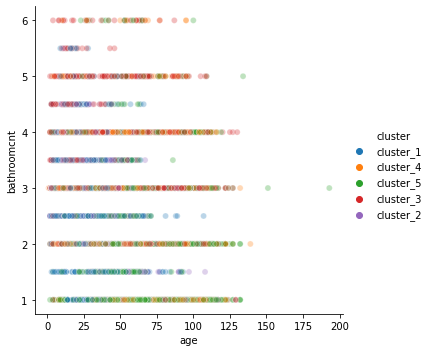

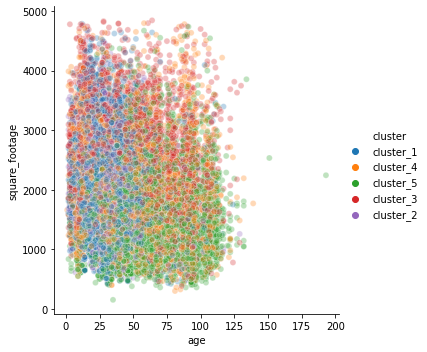

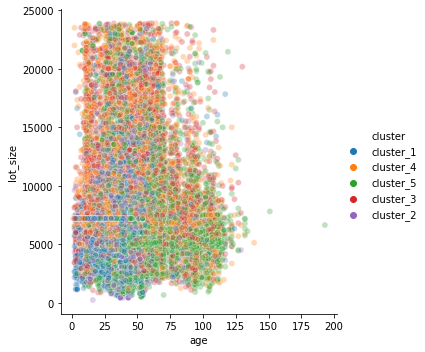

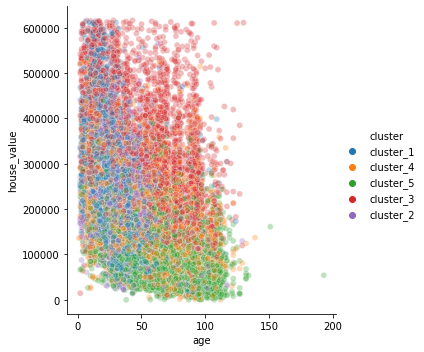

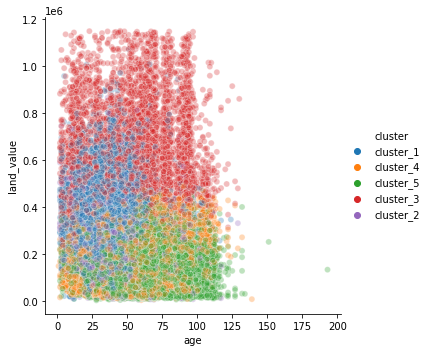

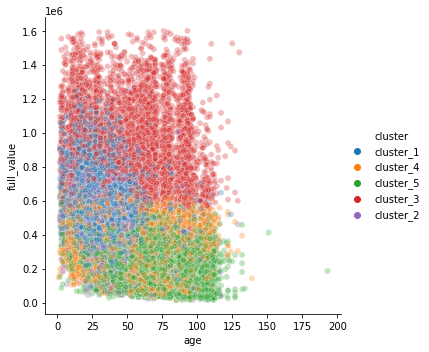

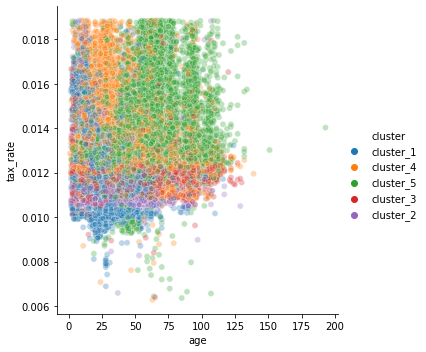

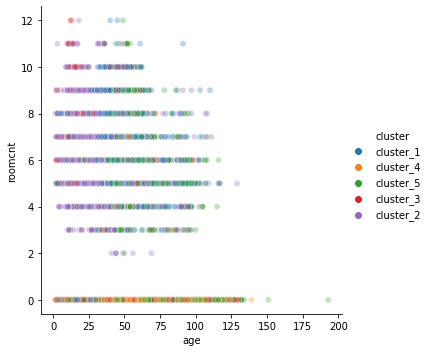

In [ ]:
cluster.k_cluster_all(train, "age", 5)

In [ ]:
cluster.elbow(train[["latitude","longitude"]], 10)

In [ ]:
cluster.k_cluster_2d(train, "latitude", "longitude", 4, 3)

Target Exploration

In [ ]:
# overall logerror distribution 
sns.distplot(df.logerror)

In [ ]:
# absolute value of logerror
sns.kdeplot(df.logerror.abs(), shade=True)
plt.show()

Correlation between Features/ Target

In [ ]:
# Overall correlation of the features and the target.
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='Greens', annot=True)

In [ ]:
plt.figure(figsize=(14,8))
sns.lineplot(x = train.age, y = train.logerror.abs())
plt.xlabel('Home Age')
plt.ylabel('Log Error')
plt.title('Does home age correlate with log error?')
plt.show

In [ ]:
plt.figure(figsize=(14,8))
sns.lineplot(train.month, train.logerror.abs())
plt.xlabel('Month of the Transaction')
plt.ylabel('Log Error')
plt.title('Does transaction date correlate with Log Error?')
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
with sns.color_palette('Blues'):
    sns.barplot(x='bathroomcnt', y='logerror', data=train)
plt.xlabel('Bathroom Count')
plt.ylabel('Log Error')
plt.title('Does bathroom count impact log error?')
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
with sns.color_palette("Blues"):
    sns.barplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Log Error')
plt.title('Does bedroom count impact log error?')
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='tax_rate', y='logerror', data=train, alpha=.4)
plt.xlabel('Tax Rate')
plt.ylabel('Log Error')
plt.title('Does tax rate impact log error?')
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='square_footage', y='logerror', data=train, alpha=.4)
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')
plt.title('Does the finished square feet of a home impact log error?')
plt.show()

In [ ]:
# parcelDensity30000 = cluster.get_pde(df,30000)

# plt.figure(figsize=(14,14))
# plt.axis("off")
# plt.title("Parcel Density Estimation")
# plt.scatter(df['longitude'].values, df['latitude'].values, c=parcelDensity30000,cmap='inferno', s=1, edgecolor='')
# plt.show()

Feature Engineering

In [ ]:
train_size_age = train_scaled[["square_footage","lot_size","age"]]
test_size_age = test_scaled[["square_footage","lot_size","age"]]

train_location_tax = train_scaled[["latitude","longitude","tax_rate"]]
test_locaction_tax = test_scaled[["latitude","longitude","tax_rate"]]

In [ ]:
cluster.elbow(train_size_age)

In [ ]:
cluster.k_cluster_3d(train_size_age,"square_footage","age","lot_size", 5)

In [ ]:
cluster.elbow(train_location_tax)

In [ ]:
cluster.k_cluster_3d(train_location_tax,"latitude","longitude","tax_rate", 5)

Create cluster values from the seen clusters above

In [ ]:
# def kmeans_model(df,n):
#     kmeans = KMeans(n_clusters=n, random_state=123)
#     kmeans.fit(df)
#     return kmeans.labels_

train["cluster_sf_a_ls"] = model.kmeans_model(train_home,5)
train["cluster_loc_tax"] = model.kmeans_model(train_loc,5)

test["cluster_sf_a_ls"] = model.kmeans_model(test_home,5)
test["cluster_loc_tax"] = model.kmeans_model(test_loc,5)